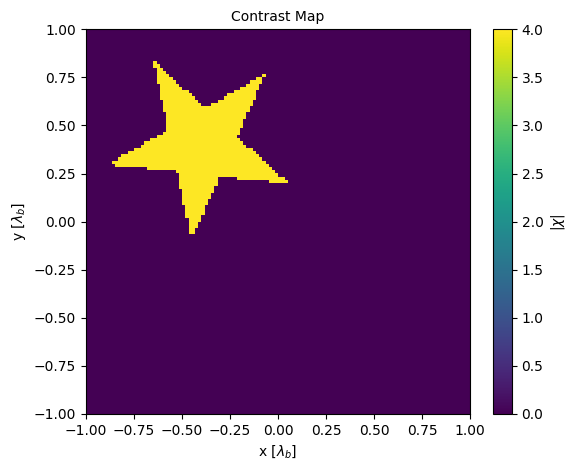

Execution time: 992.72 [sec]


In [2]:
import sys
sys.path.insert(1, '../../../eispy2d/library/')

import configuration as cfg
import inputdata as ipt
import result as rst
import draw
import mom_cg_fft as mom

# Parameters
name = 'single'
file_path = "../../../data/position/single/"
NM = NS = 80
Ro = 4.
lambda_b = 1.
epsilon_rb = 1.
Lx = Ly = 2.
E0 = 1.
perfect_dielectric = True
resolution = (120, 120)
noise = 5.
indicators = [rst.SHAPE_ERROR, rst.POSITION_ERROR, rst.OBJECTIVE_FUNCTION]
epsilon_rd = 5. # 6.00
l = 0.5
position = [.4, -.4]
rotate = 30

config = cfg.Configuration(name=name + '.cfg', number_measurements=NM, 
                           number_sources=NS, observation_radius=Ro, 
                           wavelength=lambda_b,
                           background_permittivity=epsilon_rb,
                           image_size=[Ly, Lx], magnitude=E0,
                           perfect_dielectric=perfect_dielectric)


test = ipt.InputData(name=name + '.ipt', configuration=config, 
                     resolution=resolution, noise=noise, indicators=indicators)

chi = (epsilon_rd-epsilon_rb)/epsilon_rb

test.rel_permittivity, _ = draw.star5(
    l, axis_length_x=Lx, axis_length_y=Ly, resolution=resolution,
    background_rel_permittivity=epsilon_rb, object_rel_permittivity=epsilon_rd,
    center=position, rotate=30.
)

test.draw(show=True)

forward = mom.MoM_CG_FFT(tolerance=1e-3, maximum_iterations=10000,
                         parallelization=True)

_ = forward.solve(test, PRINT_INFO=True)

In [19]:
import bornapprox as ba
import regularization as reg
import richmond as ric

resolution = (40, 40)
discretization = ric.Richmond(configuration=config,
                              elements=resolution)
regularization = reg.Tikhonov(reg.TIK_FIXED, parameter=1e0)
method = ba.FirstOrderBornApproximation(regularization)
result = method.solve(test, discretization)
result.plot_map(show=True)

Method: First-Order Born Approximation
Alias: ba
Input Data: star4.ipt
Discretization: Richmond Method (40x40)
Parallelization: False
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Regularization Method: Tikhonov
Choice strategy: fixed
Parameter value: 1.000e+00


MissingInputError: The argument objective_function is missing at the function Result.update_error!

Method: Subspace-based Optimization Method
Alias: som
Input Data: single.ipt
Discretization: Richmond Method (40x40)
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Stop Criteria
Maximum number of iterations: 300
Iteration: 1 -  Shape: 147.79, Position: 1.80, Ob. Func.: 5.538e+01,
Iteration: 2 -  Shape: 177.36, Position: 1.02, Ob. Func.: 3.774e+01,
Iteration: 3 -  Shape: 188.22, Position: 0.76, Ob. Func.: 3.017e+01,
Iteration: 4 -  Shape: 195.74, Position: 0.83, Ob. Func.: 2.598e+01,
Iteration: 5 -  Shape: 199.42, Position: 0.86, Ob. Func.: 2.330e+01,
Iteration: 6 -  Shape: 204.26, Position: 0.81, Ob. Func.: 2.121e+01,
Iteration: 7 -  Shape: 209.94, Position: 0.58, Ob. Func.: 1.973e+01,
Iteration: 8 -  Shape: 212.53, Position: 0.50, Ob. Func.: 1.864e+01,
Iteration: 9 -  Shape: 217.04, Position: 0.61, Ob. Func.: 1.786e+01,
Iteration: 10 -  Shape: 221.55, Position: 0.53, Ob. Func.: 1.721e+01,
Iteration: 20 -  Shape: 217.38, Position: 0.03, Ob. Func.: 1.440e+01,
Iteration:

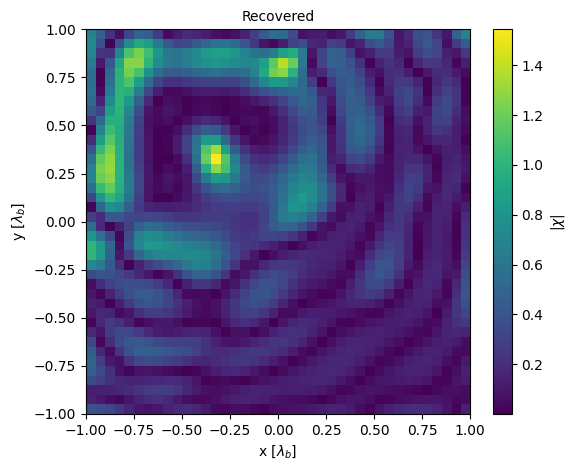

In [11]:
import som
import stopcriteria as stp
import richmond as ric

resolution = (40, 40)

discretization = ric.Richmond(configuration=config,
                              elements=resolution)

method = som.SubspaceBasedOptimizationMethod(
    stp.StopCriteria(max_iterations=300), cutoff_index=5
)

result = method.solve(test, discretization, print_info=True)

result.plot_map(show=True)

In [17]:
test.name = "star4.ipt"
test.save(file_path=file_path)